In [10]:
from load_data import load_data
from preprocess_data import preprocess_text

In [11]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report
from utils import *

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [12]:
df = load_data(with_DS3=True)
df['clean_text'] = df['comment_text'].apply(preprocess_text)

Train samples = 159571
Test cleaned samples = 63978


e:\POLYTEHNICA BUCHAREST\NLP_SSL_Project\Project\preprocess_data.py:108: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
e:\POLYTEHNICA BUCHAREST\NLP_SSL_Project\Project\preprocess_data.py:108: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


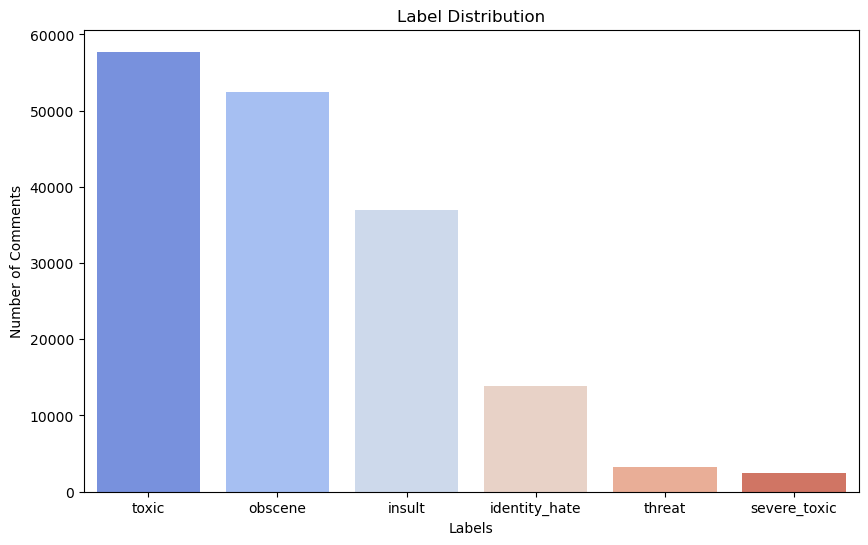

In [13]:
plot_label_distribution(df)

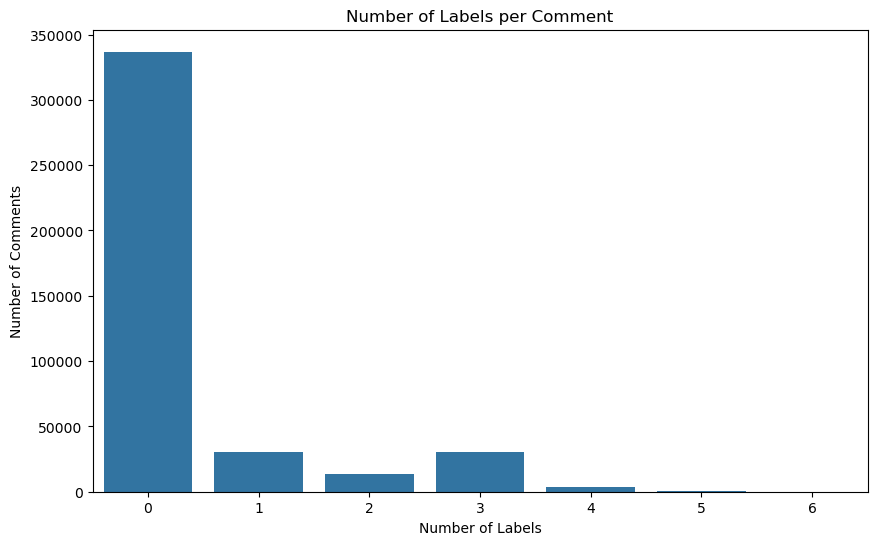

In [14]:
plot_labels_per_comment(df)

In [15]:
print(df.iloc[1, 1])
print(df.iloc[1, -1])

D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
aww match background colour seemingly stuck thanks talk january utc


In [16]:
def train_lstm(X_train, Y_train, X_val, Y_val, max_words=20000, max_len=200):
    # Tokenize
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train)

    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_val_seq = tokenizer.texts_to_sequences(X_val)

    X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
    X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)

    model = Sequential([
        Embedding(input_dim=max_words, output_dim=128),
        LSTM(128, return_sequences=False),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(6, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    f1_callback = F1ScoreCallback(X_val_pad, Y_val)

    history = model.fit(
        X_train_pad, Y_train,
        validation_data=(X_val_pad, Y_val),
        batch_size=128,
        epochs=5,
        callbacks=[EarlyStopping(patience=2, restore_best_weights=True), f1_callback]
    )

    plot_f1_history(f1_callback.f1_scores)
    
    return model, tokenizer, history

In [17]:
def evaluate_model(model, tokenizer, X_test, Y_test, max_len=200):
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

    y_pred_probs = model.predict(X_test_pad)
    y_pred = (y_pred_probs >= 0.5).astype(int)

    print(classification_report(Y_test, y_pred, target_names=Y_test.columns, zero_division=0))
    return y_pred

Epoch 1/5
2589/2589 [==============================] - 270s 103ms/step - loss: 0.0753 - accuracy: 0.8155 - val_loss: 0.0524 - val_accuracy: 0.9357

Epoch 1: val_f1_score: 0.7172
Epoch 2/5
2589/2589 [==============================] - 266s 103ms/step - loss: 0.0473 - accuracy: 0.8050 - val_loss: 0.0481 - val_accuracy: 0.8541

Epoch 2: val_f1_score: 0.7577
Epoch 3/5
2589/2589 [==============================] - 264s 102ms/step - loss: 0.0402 - accuracy: 0.7968 - val_loss: 0.0478 - val_accuracy: 0.8559

Epoch 3: val_f1_score: 0.7794
Epoch 4/5
2589/2589 [==============================] - 267s 103ms/step - loss: 0.0348 - accuracy: 0.8055 - val_loss: 0.0507 - val_accuracy: 0.8050

Epoch 4: val_f1_score: 0.7916
Epoch 5/5
2589/2589 [==============================] - 268s 103ms/step - loss: 0.0303 - accuracy: 0.8187 - val_loss: 0.0547 - val_accuracy: 0.8517

Epoch 5: val_f1_score: 0.7794


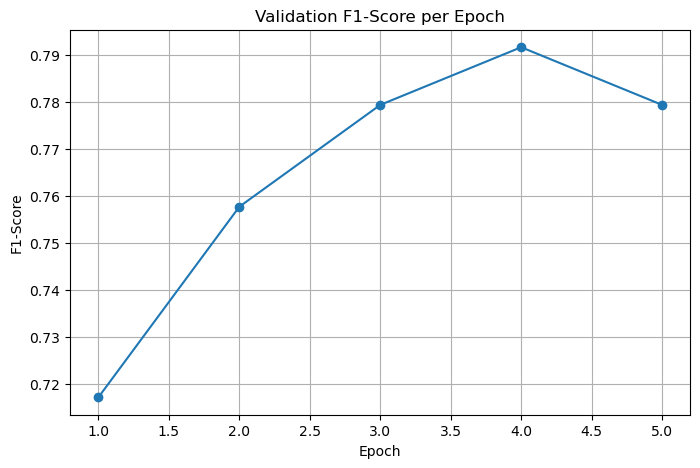

In [21]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = prepare_and_split(df)
model, tokenizer, history = train_lstm(X_train, Y_train, X_val, Y_val)

In [23]:
y_pred = evaluate_model(model, tokenizer, X_test, Y_test)

               precision    recall  f1-score   support

        toxic       0.91      0.84      0.87      5869
 severe_toxic       0.73      0.22      0.34       265
      obscene       0.94      0.89      0.92      5381
       threat       0.91      0.73      0.81       329
       insult       0.89      0.83      0.86      3815
identity_hate       0.97      0.76      0.85      1371

    micro avg       0.92      0.83      0.87     17030
    macro avg       0.89      0.71      0.77     17030
 weighted avg       0.92      0.83      0.87     17030
  samples avg       0.16      0.16      0.16     17030



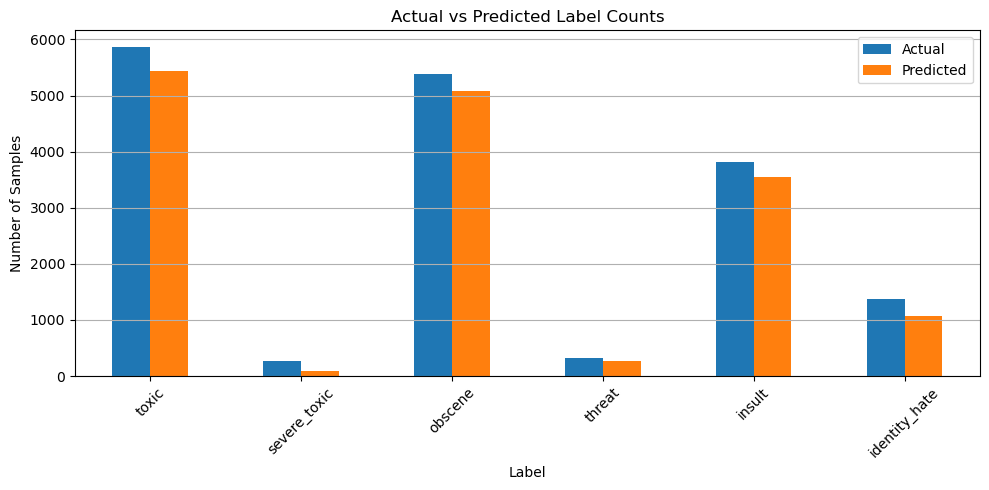

In [24]:
plot_actual_vs_predicted(Y_test, y_pred, Y_test.columns)